In [9]:
# ▶ RUN THIS CELL: Import required libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

os.makedirs('imgs', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

# Figure settings for presentation-quality plots
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 16

print('✓ Imports successful!')

✓ Imports successful!


In [2]:
# ▶ RUN THIS CELL: Load connectome data
import os
import pandas as pd

# Configuration
DATASET = 'fafb_783'
REGION = 'central_complex'

# Try local path first, then GCS
LOCAL_PATH = f'data/{DATASET}_{REGION}_synapses.feather'
GCS_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_synapses.feather'

if os.path.exists(LOCAL_PATH):
    print(f'Loading from local: {LOCAL_PATH}')
    synapses_df = pd.read_feather(LOCAL_PATH)
else:
    print(f'Loading from GCS: {GCS_PATH}')
    import gcsfs
    gcs = gcsfs.GCSFileSystem(token='google_default')
    with gcs.open(GCS_PATH.replace('gs://', ''), 'rb') as f:
        import pyarrow.feather as feather
        synapses_df = feather.read_feather(f)

print(f'✓ Loaded {len(synapses_df):,} synapses')
print(f'  Columns: {list(synapses_df.columns)}')
synapses_df.head()

Loading from GCS: gs://sjcabs_2025_data/fafb/central_complex/fafb_783_central_complex_synapses.feather
✓ Loaded 1,820,042 synapses
  Columns: ['id', 'connector_id', 'x', 'y', 'z', 'confidence', 'syn_top_nt', 'syn_top_p', 'gaba', 'acetylcholine', 'glutamate', 'octopamine', 'serotonin', 'dopamine', 'prepost', 'pre', 'post', 'neuropil', 'pre_label', 'post_label', 'side']


,id,connector_id,x,y,z,confidence,syn_top_nt,syn_top_p,gaba,acetylcholine,...,octopamine,serotonin,dopamine,prepost,pre,post,neuropil,pre_label,post_label,side
0,37903271,8415165437,435587,268526,197920,142,dopamine,0.49,0.02,0.31,...,0.00,0.14,0.49,0,720575940602430944,720575940621854563,IPS,axon,axon,right
1,38453376,8415165437,440918,258788,197240,132,acetylcholine,0.87,0.03,0.87,...,0.01,0.02,0.07,0,720575940602430944,720575940631537735,IPS,axon,axon,right
2,133622988,4758879023,430782,250449,104440,137,acetylcholine,0.97,0.00,0.97,...,0.02,0.00,0.01,0,720575940602430944,720575940624323475,LAL,axon,unknown,right
3,171205160,8415165437,442883,253256,200480,63,acetylcholine,0.98,0.00,0.98,...,0.00,0.00,0.01,0,720575940602430944,720575940631537735,IPS,axon,axon,right
4,40090700,5005274937,560716,178635,129400,157,acetylcholine,0.97,0.00,0.97,...,0.00,0.00,0.03,0,720575940602747360,720575940613326250,FB,axon,dendrite,None


In [3]:
# ▶ RUN THIS CELL: Build NetworkX graph from synapse data

# Create directed graph from synapse data
# Each row is a synapse: pre -> post
G_connectome = nx.DiGraph()

# Add edges (multiple synapses between same neurons become edge weight)
edge_counts = synapses_df.groupby(['pre', 'post']).size().reset_index(name='weight')
for _, row in edge_counts.iterrows():
    G_connectome.add_edge(row['pre'], row['post'], weight=row['weight'])

print(f'✓ Built connectome graph')
print(f'  Nodes: {G_connectome.number_of_nodes():,}')
print(f'  Edges: {G_connectome.number_of_edges():,}')
print(f'  Density: {nx.density(G_connectome):.4f}')

# Store density for later use
CONNECTOME_DENSITY = nx.density(G_connectome)


✓ Built connectome graph
  Nodes: 10,572
  Edges: 340,036
  Density: 0.0030


In [4]:
# Regenerate as ER random graphs (using same density)
G_A = nx.gnp_random_graph(20, 0.2, seed=42, directed=True)
G_B = nx.gnp_random_graph(40, 0.2, seed=43, directed=True)

In [5]:
# Graph-tool motif analysis
print('=' * 60)
print('GRAPH-TOOL MOTIF ANALYSIS')
print('=' * 60)

try:
    import graph_tool.all as gt
    GRAPH_TOOL_AVAILABLE = True
    print('✓ graph-tool successfully imported')
except ImportError:
    GRAPH_TOOL_AVAILABLE = False
    print('✗ graph-tool not available, will use NetworkX fallback')

if GRAPH_TOOL_AVAILABLE:
    # Convert NetworkX graphs to graph-tool format
    def nx_to_gt(G_nx):
        """Convert NetworkX DiGraph to graph-tool Graph"""
        G_gt = gt.Graph(directed=True)
        
        # Add vertices
        node_to_vertex = {}
        for node in G_nx.nodes():
            v = G_gt.add_vertex()
            node_to_vertex[node] = v
        
        # Add edges
        for u, v in G_nx.edges():
            G_gt.add_edge(node_to_vertex[u], node_to_vertex[v])
        
        return G_gt, node_to_vertex
    
    print('\nConverting networks to graph-tool format...')
    G_A_gt, node_map_A = nx_to_gt(G_A)
    G_B_gt, node_map_B = nx_to_gt(G_B)
    
    print(f'Network A: {G_A_gt.num_vertices()} vertices, {G_A_gt.num_edges()} edges')
    print(f'Network B: {G_B_gt.num_vertices()} vertices, {G_B_gt.num_edges()} edges')
    
else:
    print('\nSkipping graph-tool analysis (not available)')
    G_A_gt = None
    G_B_gt = None

GRAPH-TOOL MOTIF ANALYSIS
✓ graph-tool successfully imported

Converting networks to graph-tool format...
Network A: 20 vertices, 70 edges
Network B: 40 vertices, 295 edges


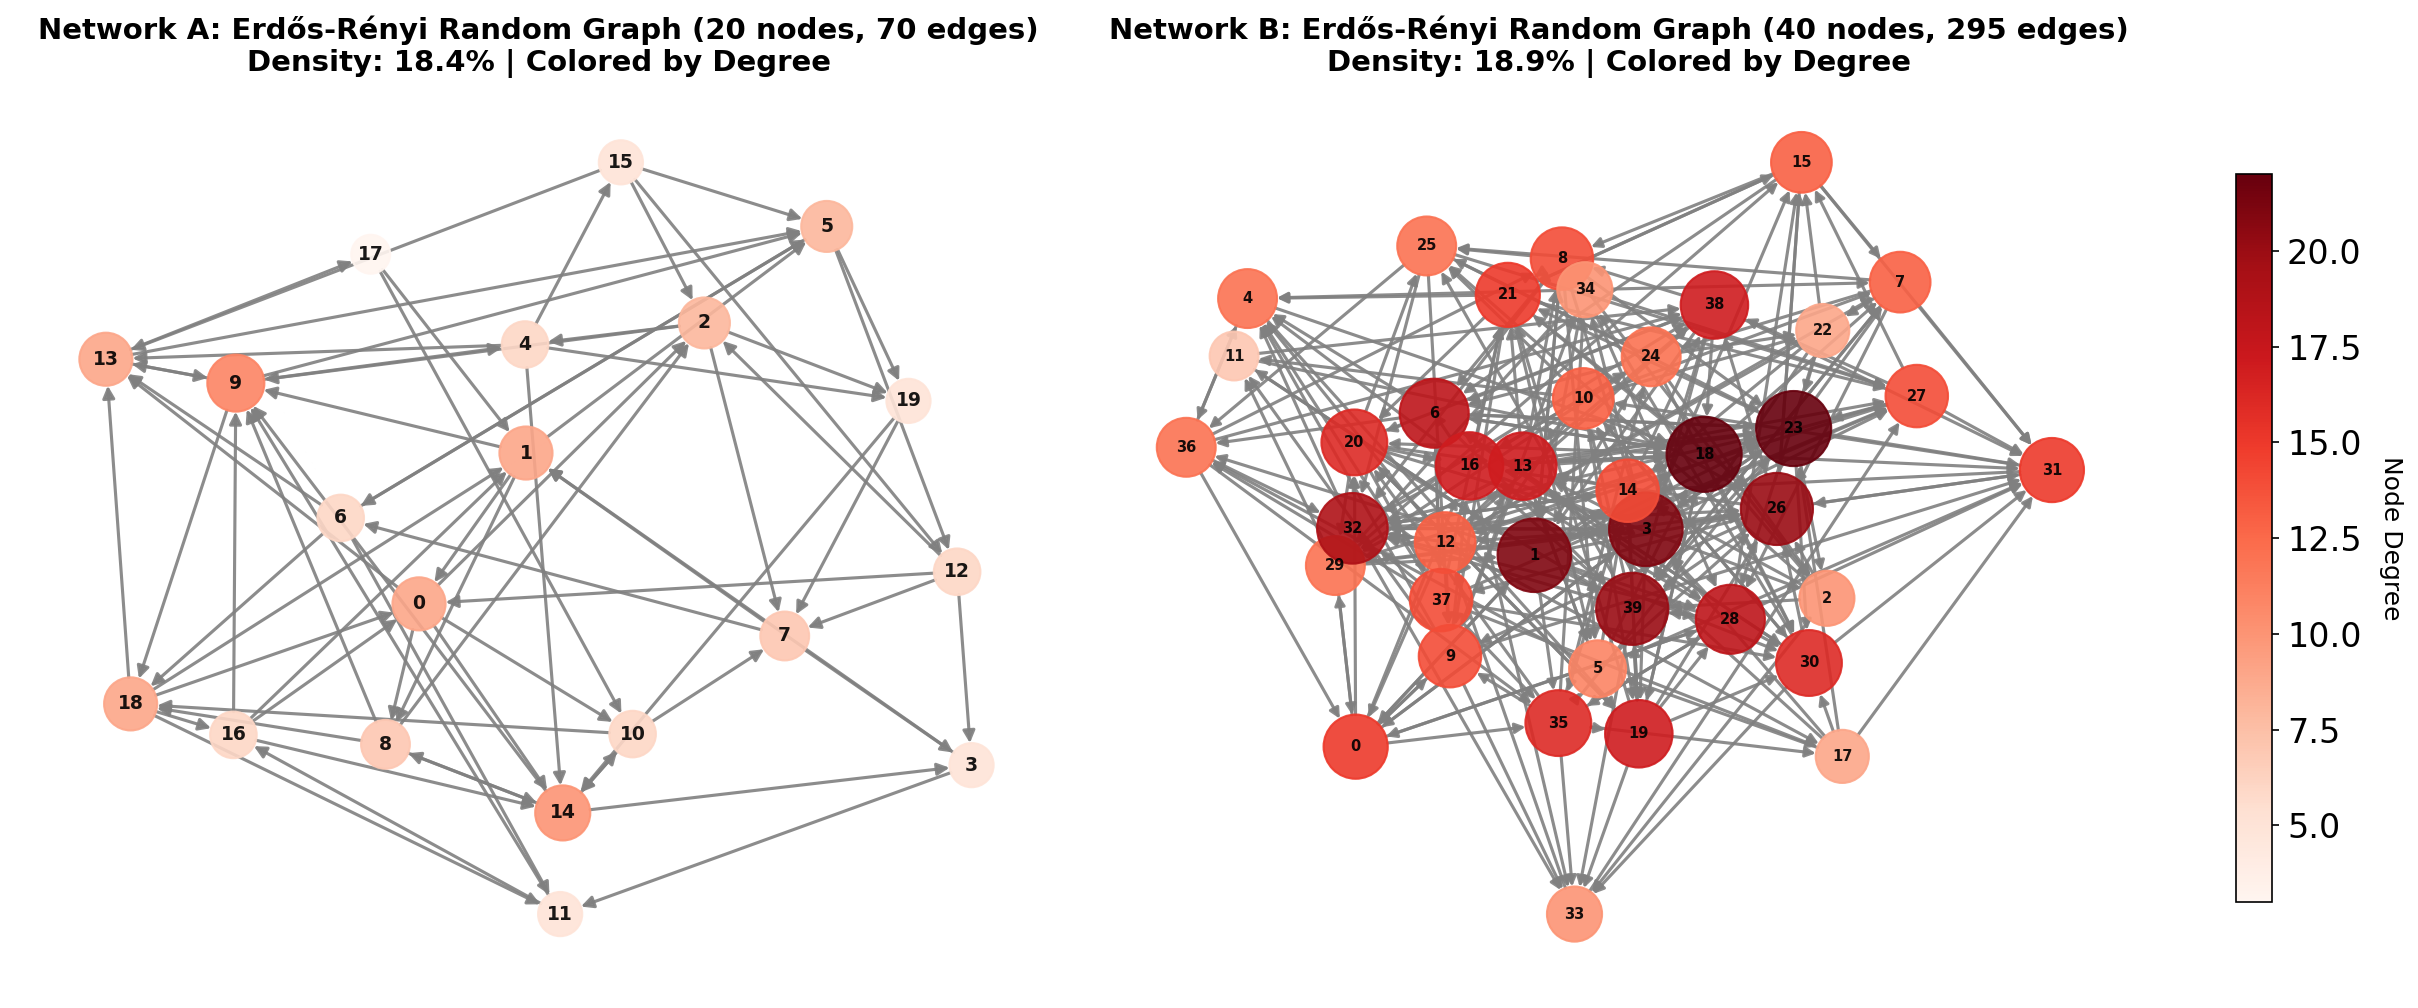

✓ Saved: imgs/fig_networks_A_B.png

Network Comparison:
  Network A: 20 nodes, 70 edges, density=18.4%
  Network B: 40 nodes, 295 edges, density=18.9%
  Both colored by node degree (red scale)


In [10]:
degrees_B = dict(G_B.degree())
# [FIGURE] Network visualizations of Graph A and Graph B
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Network A (20 nodes) - small-world
pos_A_viz = nx.spring_layout(G_A, seed=42)

# Color nodes by degree
degrees_A = dict(G_A.degree())
node_colors_A = [degrees_A[n] for n in G_A.nodes()]
node_sizes_A = [degrees_A[n] * 50 + 200 for n in G_A.nodes()]

nx.draw(G_A, pos_A_viz, ax=axes[0], 
        node_color=node_colors_A, 
        node_size=node_sizes_A,
        cmap=plt.cm.Reds,
        with_labels=True, 
        font_size=9,
        font_weight='bold',
        edge_color='gray',
        arrows=True,
        arrowsize=12,
        alpha=0.9,
        width=1.5,
        vmin=min(min(node_colors_A), min([degrees_B[n] for n in G_B.nodes()])),
        vmax=max(max(node_colors_A), max([degrees_B[n] for n in G_B.nodes()])))

axes[0].set_title(f'Network A: Erdős-Rényi Random Graph (20 nodes, {G_A.number_of_edges()} edges)\n' +
                 f'Density: {nx.density(G_A):.1%} | Colored by Degree',
                 fontsize=14, fontweight='bold')

# Network B (40 nodes) - Erdős-Rényi random graph
pos_B_viz = nx.spring_layout(G_B, seed=42)

# Color nodes by degree (same as Network A)
node_colors_B = [degrees_B[n] for n in G_B.nodes()]
node_sizes_B = [degrees_B[n] * 50 + 200 for n in G_B.nodes()]

nx.draw(G_B, pos_B_viz, ax=axes[1],
        node_color=node_colors_B,
        node_size=node_sizes_B,
        cmap=plt.cm.Reds,
        with_labels=True,
        font_size=7,
        font_weight='bold',
        edge_color='gray',
        arrows=True,
        arrowsize=10,
        alpha=0.9,
        width=1.5,
        vmin=min(min(node_colors_A), min(node_colors_B)),
        vmax=max(max(node_colors_A), max(node_colors_B)))

axes[1].set_title(f'Network B: Erdős-Rényi Random Graph (40 nodes, {G_B.number_of_edges()} edges)\n' +
                 f'Density: {nx.density(G_B):.1%} | Colored by Degree',
                 fontsize=14, fontweight='bold')

# Add shared colorbar for degree (positioned outside on the right)
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                          norm=plt.Normalize(vmin=min(min(node_colors_A), min(node_colors_B)), 
                                           vmax=max(max(node_colors_A), max(node_colors_B))))
sm.set_array([])
plt.tight_layout()
cbar = fig.colorbar(sm, ax=axes, fraction=0.046, pad=0.04, shrink=0.8)
cbar.set_label('Node Degree', rotation=270, labelpad=20, fontsize=12)
plt.savefig('imgs/fig_networks_A_B.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Saved: imgs/fig_networks_A_B.png')
print(f'\nNetwork Comparison:')
print(f'  Network A: {G_A.number_of_nodes()} nodes, {G_A.number_of_edges()} edges, density={nx.density(G_A):.1%}')
print(f'  Network B: {G_B.number_of_nodes()} nodes, {G_B.number_of_edges()} edges, density={nx.density(G_B):.1%}')
print(f'  Both colored by node degree (red scale)')

In [11]:
# Motif enumeration for 3-node motifs (triads)
if GRAPH_TOOL_AVAILABLE:
    print('\n' + '=' * 60)
    print('3-NODE MOTIF ANALYSIS (TRIADS)')
    print('=' * 60)
    
    # Count 3-node motifs (size k=3)
    print('\nCounting 3-node motifs...')
    print('(This may take a moment...)')
    
    # Network A
    motifs_A, counts_A = gt.motifs(G_A_gt, k=3)
    # motifs_A is a list of Graph objects, counts_A is a list of counts
    # Store as list of (motif_index, count) pairs
    motif_data_A = [(i, int(counts_A[i])) for i in range(len(counts_A)) if counts_A[i] > 0]
    
    # Network B  
    motifs_B, counts_B = gt.motifs(G_B_gt, k=3)
    motif_data_B = [(i, int(counts_B[i])) for i in range(len(counts_B)) if counts_B[i] > 0]
    
    print('\n' + '-' * 60)
    print('NETWORK A (20 nodes):')
    print('-' * 60)
    print(f'{"Motif Index":<15} {"Count":>10} {"Edges in Motif":>15}')
    print('-' * 60)
    
    for motif_idx, count in motif_data_A:
        n_edges = motifs_A[motif_idx].num_edges()
        print(f'{motif_idx:<15} {count:>10} {n_edges:>15}')
    
    total_count_A = sum([x[1] for x in motif_data_A])
    print(f'\nTotal 3-node motif types found: {len(motif_data_A)}')
    print(f'Total 3-node subgraph instances: {total_count_A}')
    
    print('\n' + '-' * 60)
    print('NETWORK B (40 nodes):')
    print('-' * 60)
    print(f'{"Motif Index":<15} {"Count":>10} {"Edges in Motif":>15}')
    print('-' * 60)
    
    for motif_idx, count in motif_data_B:
        n_edges = motifs_B[motif_idx].num_edges()
        print(f'{motif_idx:<15} {count:>10} {n_edges:>15}')
    
    total_count_B = sum([x[1] for x in motif_data_B])
    print(f'\nTotal 3-node motif types found: {len(motif_data_B)}')
    print(f'Total 3-node subgraph instances: {total_count_B}')
    
    print('\n💡 KEY INSIGHT:')
    print('   Graph-tool uses a canonical labeling system for motifs')
    print('   Each motif index represents a unique 3-node subgraph topology')
    print('   Higher index = more edges/complexity in the motif')
    
else:
    print('\nSkipping motif analysis (graph-tool not available)')


3-NODE MOTIF ANALYSIS (TRIADS)

Counting 3-node motifs...
(This may take a moment...)

------------------------------------------------------------
NETWORK A (20 nodes):
------------------------------------------------------------
Motif Index          Count  Edges in Motif
------------------------------------------------------------
0                       44               2
1                       53               2
2                      136               2
3                       30               3
4                       12               3
5                       21               3
6                        8               3
7                        2               4
8                        2               4
9                        3               4
10                       1               4

Total 3-node motif types found: 11
Total 3-node subgraph instances: 312

------------------------------------------------------------
NETWORK B (40 nodes):
----------------------------------

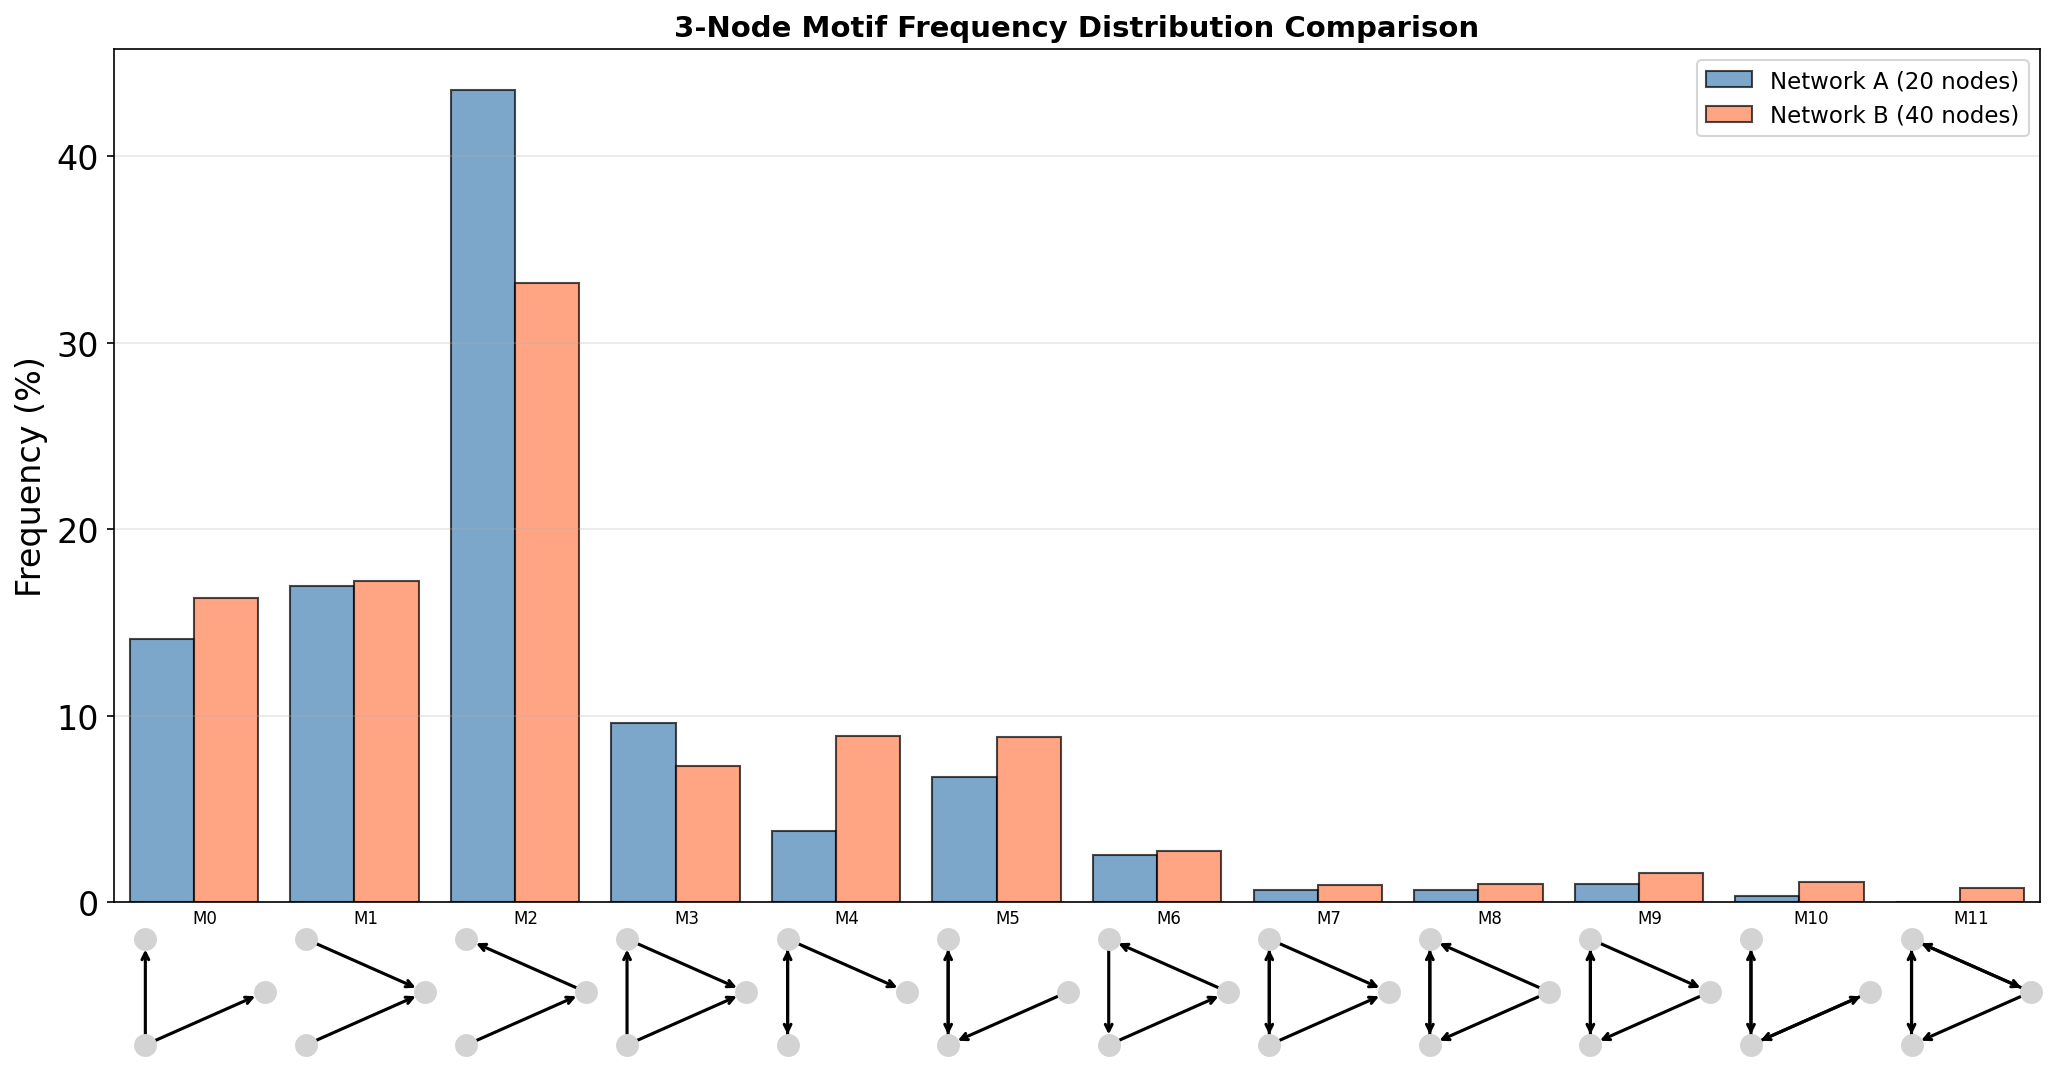

✓ Saved: imgs/fig_4c_graphtool_motifs.png


In [12]:
# [FIGURE] Motif comparison between networks - OVERLAID (FREQUENCY)
if GRAPH_TOOL_AVAILABLE:
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    # Get all unique motif indices from both networks
    motif_indices_A = [x[0] for x in motif_data_A]
    motif_counts_A = [x[1] for x in motif_data_A]
    
    motif_indices_B = [x[0] for x in motif_data_B]
    motif_counts_B = [x[1] for x in motif_data_B]
    
    # Calculate total counts for frequency normalization
    total_A = sum(motif_counts_A)
    total_B = sum(motif_counts_B)
    
    # Find union of motif indices
    all_motif_indices = sorted(set(motif_indices_A) | set(motif_indices_B))
    
    # Create aligned frequency arrays (as percentages)
    freq_A_aligned = [(motif_counts_A[motif_indices_A.index(idx)] / total_A * 100) if idx in motif_indices_A else 0 
                      for idx in all_motif_indices]
    freq_B_aligned = [(motif_counts_B[motif_indices_B.index(idx)] / total_B * 100) if idx in motif_indices_B else 0 
                      for idx in all_motif_indices]
    
    # Create overlaid bar plot with offset
    bar_width = 0.4
    x_pos = range(len(all_motif_indices))
    
    ax.bar([x - bar_width/2 for x in x_pos], freq_A_aligned, 
           width=bar_width, color='steelblue', edgecolor='black', alpha=0.7, label='Network A (20 nodes)')
    ax.bar([x + bar_width/2 for x in x_pos], freq_B_aligned, 
           width=bar_width, color='coral', edgecolor='black', alpha=0.7, label='Network B (40 nodes)')
    
    ax.set_ylabel('Frequency (%)')
    ax.set_title('3-Node Motif Frequency Distribution Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks([])  # Remove default x-ticks
    ax.set_xlim(-0.5, len(all_motif_indices) - 0.5)
    ax.legend(loc='upper right', fontsize=11)
    
    # Draw mini motif topologies on x-axis
    for bar_idx, motif_idx in enumerate(all_motif_indices):
        # Create inset axes for mini graph
        inset = ax.inset_axes([bar_idx / len(all_motif_indices) + 0.01, -0.18, 
                               0.9 / len(all_motif_indices), 0.15], 
                              transform=ax.transAxes)
        
        # Use motif from A if available, otherwise from B
        if motif_idx in motif_indices_A:
            motif_gt = motifs_A[motif_idx]
        else:
            motif_gt = motifs_B[motif_idx]
        
        # Convert graph-tool graph to networkx
        motif_nx = nx.DiGraph()
        motif_nx.add_nodes_from(range(3))
        for e in motif_gt.edges():
            motif_nx.add_edge(int(e.source()), int(e.target()))
        
        # Draw mini graph
        pos_motif = nx.circular_layout(motif_nx)
        nx.draw(motif_nx, pos_motif, ax=inset,
                node_color='lightgray', node_size=100, 
                edge_color='black', arrows=True, arrowsize=8,
                arrowstyle='->', width=1.5, with_labels=False)
        inset.axis('off')
        inset.set_title(f'M{motif_idx}', fontsize=8, pad=2)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)  # Make room for motif illustrations
    plt.savefig('imgs/fig_4c_graphtool_motifs.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved: imgs/fig_4c_graphtool_motifs.png')